<table style="border: none" align="center">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="4" color="black"><b>  Demonstrate adversarial training using ART  </b></font></font></th>
   </tr> 
</table>

In this notebook we demonstrate Model training and adversarial training using ART on the IRIS dataset.

Sensitivity to training set details:

https://nbviewer.jupyter.org/github/ageron/handson-ml2/blob/master/06_decision_trees.ipynb


https://github.com/rasbt/stat451-machine-learning-fs20


## Contents

1.	[Load prereqs and data](#prereqs)
2.  [Exploratory Data Analysis](#eda)
2.  [Data scale, Train and evaluate a baseline classifier](#classifier)
3.  [Adversarially train a robust classifier](#adv_training)
4.	[Evaluate the robust classifier](#evaluation)

<a id="prereqs"></a>
## 1. Load prereqs and data

In [90]:
#!pip install mlxtend
#!pip install watermark

In [91]:
%reload_ext watermark
%watermark  -d -u -a "Habtamu desalegn" -v -p numpy,pandas,scipy,matplotlib,sklearn,mlxtend,six,tarfile

Habtamu desalegn 
last updated: 2020-11-18 

CPython 3.8.3
IPython 7.18.1

numpy 1.19.2
pandas 1.1.3
scipy 1.4.1
matplotlib 3.3.2
sklearn 0.22.2
mlxtend 0.17.3
six 1.15.0
tarfile 0.9.0


In [92]:
import os
import sys
import six
from typing import Callable, List, Optional, Tuple, Union, TYPE_CHECKING
import shutil
import zipfile
import tarfile

import numpy as np
import pandas as pd
from IPython.display import Image

from matplotlib.colors import ListedColormap
%matplotlib inline
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

#### Loading the IRIS dataset

In [93]:
PATH = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
df = pd.read_csv(PATH, header=None)
df.head()

,0,1,2,3,4
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [94]:
X = df.iloc[:, 0:4].values
labels = df.loc[:, 4].values

#Get Class Labels into a NumPy Array
label_map = {"Iris-setosa": 0, "Iris-versicolor": 1, "Iris-virginica": 2}
y = np.array([label_map[labels[i]] for i in range(labels.size)], dtype=np.int32)

In [95]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=123,shuffle=True)

In [96]:
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (105, 4)
y_train.shape: (105,)
X_test.shape: (45, 4)
y_test.shape: (45,)


<a id="eda"></a>
## Exploratory Data Analysis

In [97]:
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test examples
    if test_idx:
        # plot all examples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

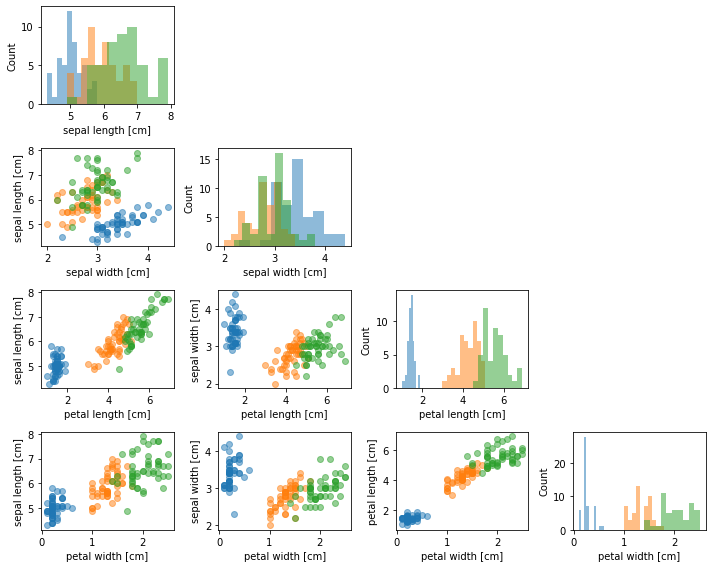

In [98]:
from mlxtend.plotting import scatterplotmatrix


names = ['sepal length [cm]', 'sepal width [cm]',
         'petal length [cm]', 'petal width [cm]']

fig, axes = scatterplotmatrix(X[y==0], figsize=(10, 8), alpha=0.5)
fig, axes = scatterplotmatrix(X[y==1], fig_axes=(fig, axes), alpha=0.5)
fig, axes = scatterplotmatrix(X[y==2], fig_axes=(fig, axes), alpha=0.5, names=names)

plt.tight_layout()
plt.show()

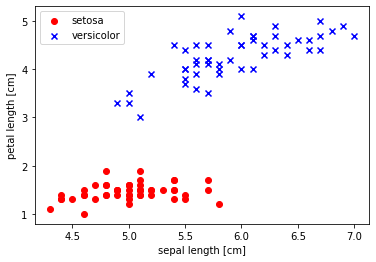

In [99]:
# select setosa and versicolor
y_temp = y[0:100]
# extract sepal length and petal length
X_temp = X[0:100, [0, 2]]

# plot data
plt.scatter(X_temp[:50, 0], X_temp[:50, 1],
            color='red', marker='o', label='setosa')
plt.scatter(X_temp[50:100, 0], X_temp[50:100, 1],
            color='blue', marker='x', label='versicolor')

plt.xlabel('sepal length [cm]')
plt.ylabel('petal length [cm]')
plt.legend(loc='upper left')

# plt.savefig('images/02_06.png', dpi=300)
plt.show()

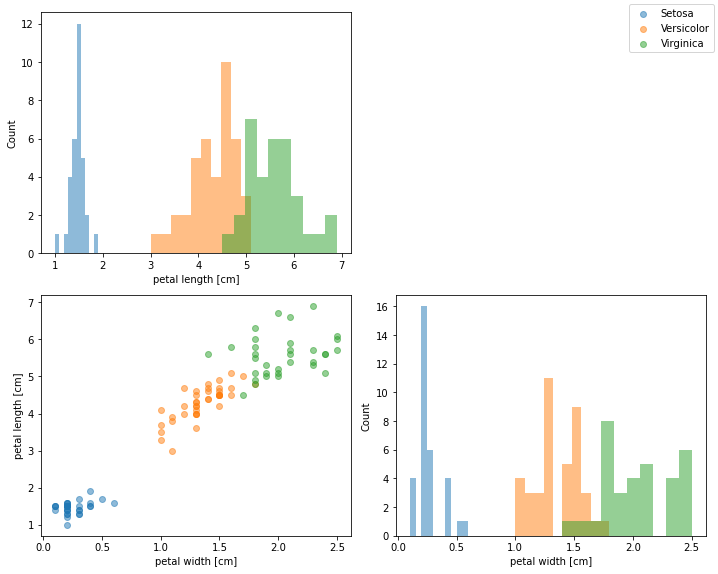

In [100]:
#  0=sepal length, 1=sepal width
#  2=petal length, 3=petal width

# petal information
names = ['petal length [cm]', 'petal width [cm]'] 

fig, axes = scatterplotmatrix(X_train[y_train==0][:,2:], figsize=(10, 8), alpha=0.5, label="Setosa")
fig, axes = scatterplotmatrix(X_train[y_train==1][:,2:], fig_axes=(fig, axes), alpha=0.5, label="Versicolor")
fig, axes = scatterplotmatrix(X_train[y_train==2][:,2:], fig_axes=(fig, axes), alpha=0.5, names=names, label="Virginica")

fig.legend()

plt.tight_layout()
plt.show()

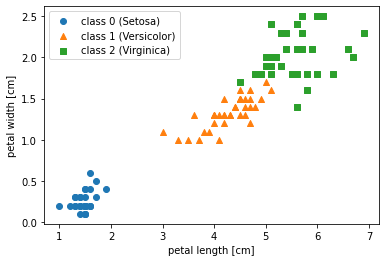

In [101]:
#  0=sepal length, 1=sepal width
#  2=petal length, 3=petal width

#petal information
plt.scatter(X_train[y_train == 0, 2],   
            X_train[y_train == 0, 3],
            marker='o',
            label='class 0 (Setosa)')

plt.scatter(X_train[y_train == 1, 2],
            X_train[y_train == 1, 3],
            marker='^',
            label='class 1 (Versicolor)')

plt.scatter(X_train[y_train == 2, 2],
            X_train[y_train == 2, 3],
            marker='s',
            label='class 2 (Virginica)')

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')

plt.show()

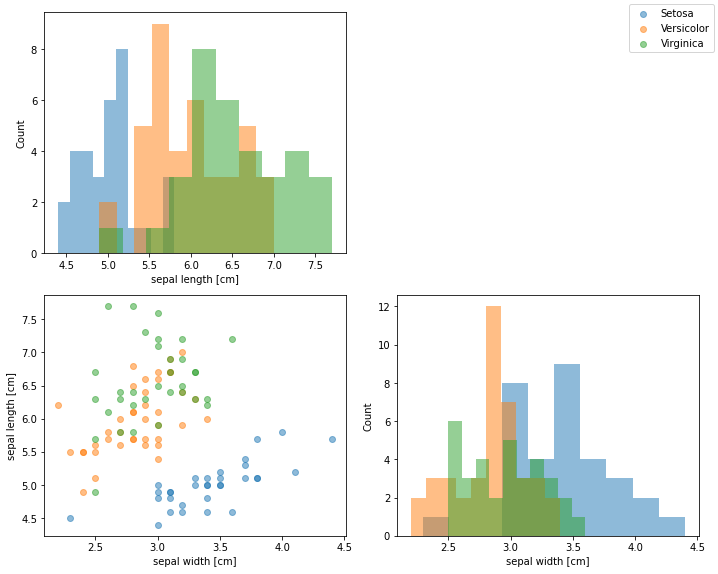

In [102]:
#  0=sepal length, 1=sepal width
#  2=petal length, 3=petal width

# sepal information
names = ['sepal length [cm]', 'sepal width [cm]']

fig, axes = scatterplotmatrix(X_train[y_train==0][:,[0,1]], figsize=(10, 8), alpha=0.5, label="Setosa")
fig, axes = scatterplotmatrix(X_train[y_train==1][:,[0,1]], fig_axes=(fig, axes), alpha=0.5, label="Versicolor")
fig, axes = scatterplotmatrix(X_train[y_train==2][:,[0,1]], fig_axes=(fig, axes), alpha=0.5, names=names, label="Virginica")

fig.legend()

plt.tight_layout()
plt.show()

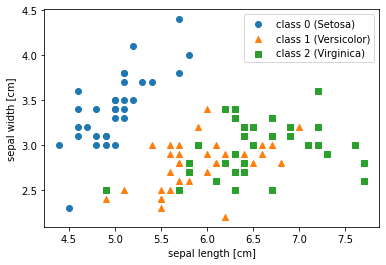

In [103]:
#  0=sepal length, 1=sepal width
#  2=petal length, 3=petal width

# sepal information
plt.scatter(X_train[y_train == 0, 0],   
            X_train[y_train == 0, 1],
            marker='o',
            label='class 0 (Setosa)')

plt.scatter(X_train[y_train == 1, 0],
            X_train[y_train == 1, 1],
            marker='^',
            label='class 1 (Versicolor)')

plt.scatter(X_train[y_train == 2, 0],
            X_train[y_train == 2, 1],
            marker='s',
            label='class 2 (Virginica)')

plt.xlabel('sepal length [cm]')
plt.ylabel('sepal width [cm]')
plt.legend(loc='upper right')

plt.show()

<a id="classifier"></a>
## 2. Preprocess ,Train and Evaluate a classifier

1. [Data Scaling](#2_1)
2. [Train a model](#2_2_1)

   [Fit Decession Tree Model (sklearn)](#2_2_1)
   
   [Fit SVM Model (sklearn)](#2_2_2)
   
   [Fit k-Nearest Neighbor Model (sklearn)](#2_2_3)
   
   
3. [Evaluate the model](#2_3)

<a id="2_1"></a>
### 1. Data Scaling

Bringing features onto the same scale

In [104]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


def preprocess_minmax(X_train: np.ndarray, X_test: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Normalization -- Min-max scaling

    Scales `X_train` to [0, 1] , `X_test` to [0, 1]

    :param X_train: Data instances.
    :param X_test: Data instances.
    :return: Rescaled values of `X_train`, `X_test`.
    """
    
    # normalize
    #print('normalized:', (ex - ex.min()) / (ex.max() - ex.min()))
    
    mms = MinMaxScaler()
    X_train_norm = mms.fit_transform(X_train)
    X_test_norm = mms.transform(X_test)
    
    return X_train_norm, X_test_norm

def preprocess_standard(X_train: np.ndarray, X_test: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Standard scaling: Gaussian with zero mean and unit variance

    Scales `X_train` to [0, 1] , `X_test` to [0, 1]

    :param x: Data instances.
    :param y: Labels.
    :return: Rescaled values of `x`, `y`.
    """
    
    stdsc = StandardScaler()
    X_train_std = stdsc.fit_transform(X_train)
    X_test_std = stdsc.transform(X_test)
    
    return X_train_std, X_test_std

In [105]:
# Preprocess - Training and testing set
### standard
#(X_train, X_test) = preprocess_standard(X_train[:,[0,1]], X_test[:,[0,1]])    #  0=sepal length, 1=sepal width
(X_train, X_test) = preprocess_standard(X_train[:,2:], X_test[:,2:])           #  2=petal length, 3=petal width

### normalize
#(X_train, X_test) = preprocess_minmax(X_train[:,[0,1]], X_test[:,[0,1]])     #  0=sepal length, 1=sepal width
#(X_train, X_test) = preprocess_minmax(X_train[:,2:], X_test[:,2:])           #  2=petal length, 3=petal width

### with out normalization
#(X_train, X_test) = X_train[:,[0,1]], X_test[:,[0,1]]      #  0=sepal length, 1=sepal width
#(X_train, X_test) = X_train[:,2:], X_test[:,2:]            #  2=petal length, 3=petal width


<a id="2_2_1"></a>
### 2.1 Training a DecisionTree via scikit-learn

In [106]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(criterion='gini', 
                              max_depth=4, 
                              random_state=123)
model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')

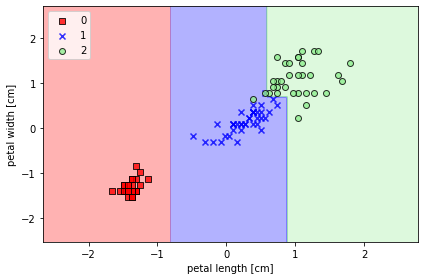

In [107]:
plot_decision_regions(X_train, y_train, model)
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

<ipython-input-97-bb5eb72466a6>:33: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(X_test[:, 0],


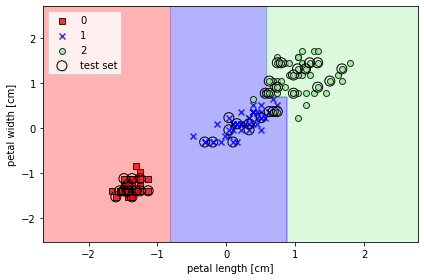

In [108]:
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, 
                      classifier=model,
                      test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_20.png', dpi=300)
plt.show()

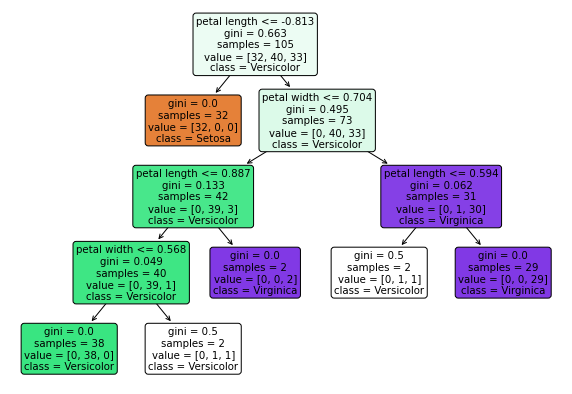

In [109]:
from sklearn.tree import plot_tree


plt.figure(figsize=(10, 7))

plot_tree(model, 
          filled=True, 
          rounded=True,
          class_names=['Setosa', 
                       'Versicolor',
                       'Virginica'],
          feature_names=['petal length', 
                         'petal width']) 

plt.show()

<a id="2_2_2"></a>
### 2.2 Training a SVM via scikit-learn

In [110]:
from sklearn.svm import SVC

model = SVC(kernel='linear', C=1.0, random_state=1)
model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=1, shrinking=True, tol=0.001,
    verbose=False)

<ipython-input-97-bb5eb72466a6>:33: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(X_test[:, 0],


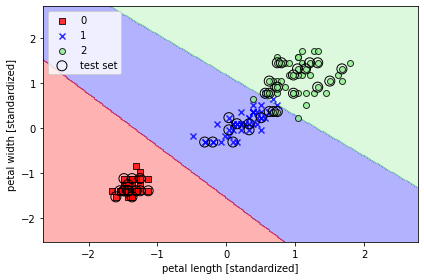

In [111]:
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X_combined, 
                      y_combined,
                      classifier=model, #svm
                      test_idx=range(105, 150))
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_11.png', dpi=300)
plt.show()


<a id="2_2_3"></a>
### 2.3 Training a k-Nearest Neighbor via scikit-learn

In [112]:
from sklearn.neighbors import KNeighborsClassifier


model = KNeighborsClassifier(n_neighbors=3)
model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

#### Visualize Decision Boundary

<ipython-input-97-bb5eb72466a6>:33: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(X_test[:, 0],


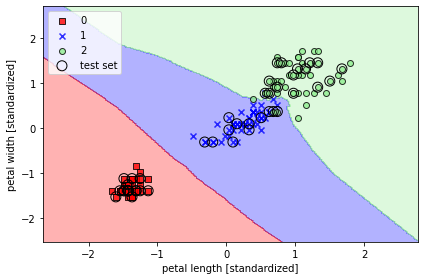

In [113]:
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(X_combined, y_combined, 
                      classifier=model, test_idx=range(105, 150)) #knn

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_24.png', dpi=300)
plt.show()

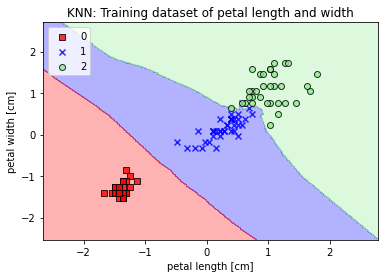

In [114]:
plot_decision_regions(X_train, y_train, model) #knn
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.title('KNN: Training dataset of petal length and width')
plt.show()

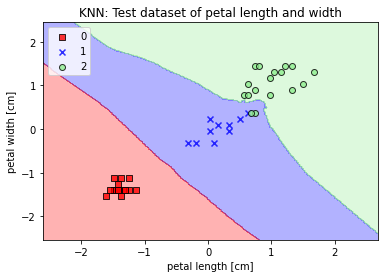

In [115]:
plot_decision_regions(X_test, y_test, model) #knn
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.title('KNN: Test dataset of petal length and width')
plt.show()

<a id="2_3"></a>
### Evaluate the model

Looking at different performance evaluation metrics

https://nbviewer.jupyter.org/github/vmirly/python-machine-learning-book-3rd-edition/blob/master/ch06/ch06.ipynb

#### Reading a confusion matrix

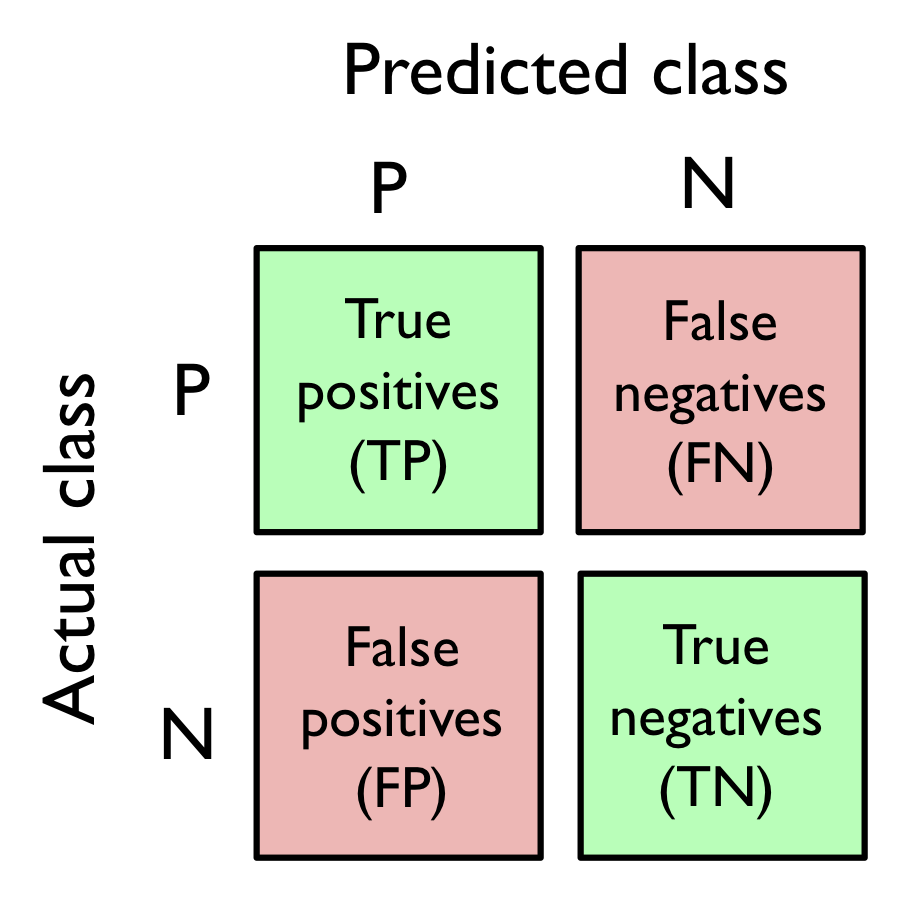

In [116]:
Image(filename='images/confusion_matrix.png', width=300) 

In [84]:
# Import the libraries
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.metrics import classification_report
from sklearn import preprocessing  # uses Binarize labels in a one-vs-all fashion

In [71]:
def multiclass_roc_auc_score(y_test, y_pred, average='micro'):
    lb = preprocessing.LabelBinarizer()
    y_test = lb.fit_transform(y_test)
    y_pred = lb.fit_transform(y_pred)
    
    return roc_auc_score(y_test, y_pred, average=average)

In [117]:
# note: micro-average is preferable if you suspect there might be class imbalance
# ref: https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin
y_pred = model.predict(X_test)
print(f"prediction: {y_pred}")
print(f'Misclassified examples:{(y_test != y_pred).sum()}')

# Confusion Matrix
conf_mat = confusion_matrix(y_test, y_pred)
print(f"confusion matrix:\n {conf_mat}")

# AUC
auc = multiclass_roc_auc_score(y_test, y_pred, average='macro')
print(f"auc: {auc}")

# Accuracy
accuracy=accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}") # way 1
print(f'Accuracy:{model.score(X_test, y_test)}') # way 2

# Precision
precision = precision_score(y_test, y_pred, average='macro')
print(f"Precision: {precision}")

# Recall
recall = recall_score(y_test, y_pred, average='macro')
print(f"Recall: {recall}")

# F1
f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1: {f1}")

# Predicting classes and class probabilities
print(f"X_test:\n {X_test[0:5,:]}")
print(f"class probabilities:\n {model.predict_proba(X_test[0:5,:])}")
print(f"Predicting classes: {model.predict(X_test[0:5,:])}")


prediction: [1 2 2 1 0 2 1 0 0 1 2 0 1 2 2 2 0 0 1 0 0 1 0 2 0 0 0 2 2 0 2 1 0 0 1 1 2
 0 0 1 1 0 2 2 2]
Misclassified examples:2
confusion matrix:
 [[18  0  0]
 [ 0 10  0]
 [ 0  2 15]]
auc: 0.9708683473389357
Accuracy: 0.9555555555555556
Accuracy:0.9555555555555556
Precision: 0.9444444444444445
Recall: 0.9607843137254902
F1: 0.9488636363636364
X_test:
 [[ 0.62298129  0.36436846]
 [ 0.97466428  1.17838309]
 [ 1.03327811  1.3140522 ]
 [ 0.15407064  0.09303024]
 [-1.36988897 -1.53499903]]
class probabilities:
 [[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]
Predicting classes: [1 2 2 1 0]


In [118]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.83      1.00      0.91        10
           2       1.00      0.88      0.94        17

    accuracy                           0.96        45
   macro avg       0.94      0.96      0.95        45
weighted avg       0.96      0.96      0.96        45



Max f1_score on max_depth   2  is  0.9488636363636364


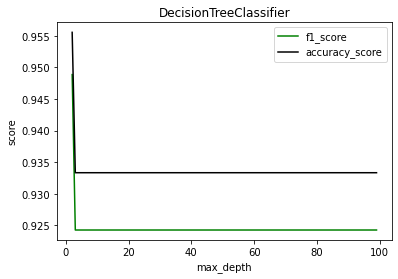

In [119]:
max_c = 0;
max_j = 0;
y_fsc = []
y_rauc = []
y_acc = []
y_ll = []

for j in range(2, 100):
    x_vals = np.arange(2, 100)
    model = DecisionTreeClassifier(max_depth = j, random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f_sc = f1_score(y_test, y_pred, average='macro')
    y_fsc.append(f_sc)
    #r_auc = multiclass_roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    #y_rauc.append(r_auc)
    acc = accuracy_score(y_test, y_pred)
    y_acc.append(acc)
    if f_sc > max_c:
        max_c = f_sc
        max_j = j

print("Max f1_score on max_depth  ",  max_j, " is ", max_c)
plt.figure()
plt.xlabel('max_depth')
plt.ylabel('score')
plt.title('DecisionTreeClassifier')
plt.plot(x_vals, y_fsc, color = "green", label = "f1_score")
#plt.plot(x_vals, y_rauc, color = "red", label = "roc_auc_score")
plt.plot(x_vals, y_acc, color = "black", label = "accuracy_score")
plt.legend()

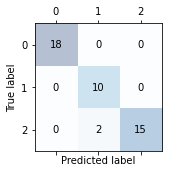

In [121]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i, s=conf_mat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('images/06_09.png', dpi=300)
plt.show()

#### K-fold cross-validation


https://nbviewer.jupyter.org/github/vmirly/python-machine-learning-book-3rd-edition/blob/master/ch06/ch06.ipynb

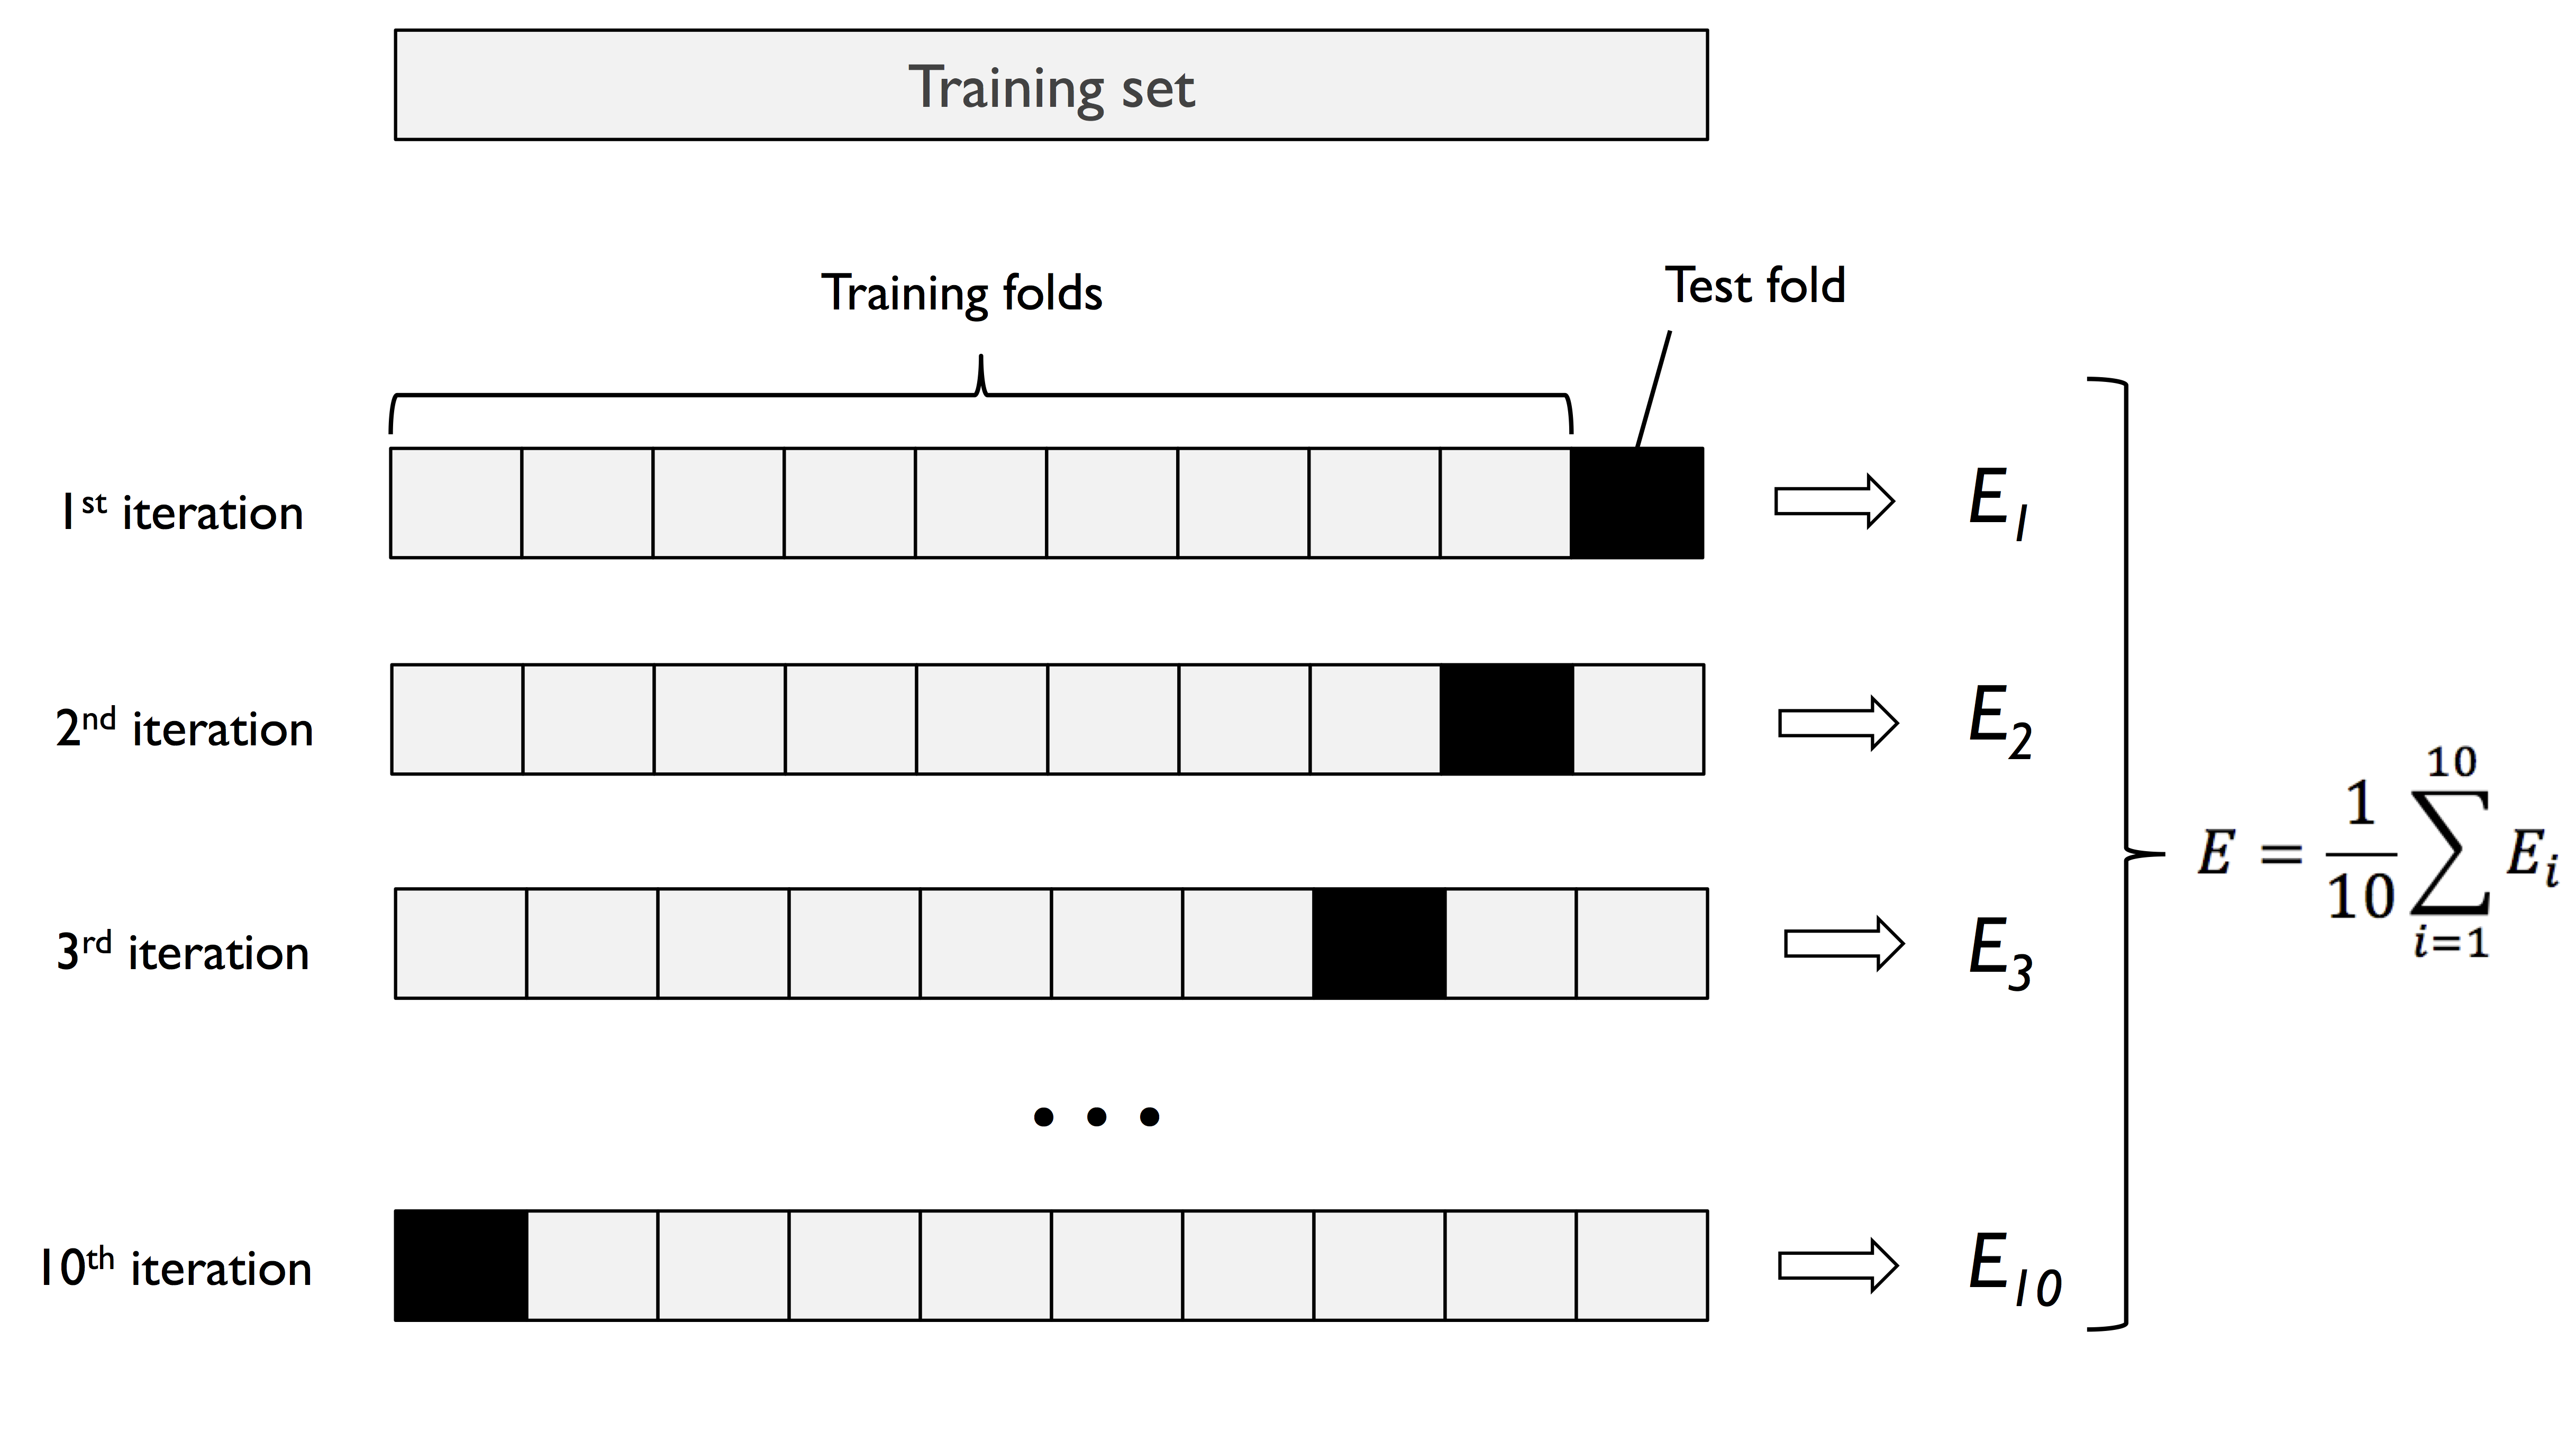

In [122]:
Image(filename='images/kfold.png', width=500)

In [127]:
from sklearn.model_selection import StratifiedKFold    

#CV accuracy: 0.973 +/- 0.044
model = SVC(kernel='linear', C=1.0, random_state=1)

#CV accuracy: 0.963 +/- 0.061
#model = KNeighborsClassifier(n_neighbors=3)

#CV accuracy: 0.953 +/- 0.043
#model = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=123)

kfold = StratifiedKFold(n_splits=10).split(X, y)
scores = []
for k, (train, test) in enumerate(kfold):
    model.fit(X[train], y[train])
    score = model.score(X[test], y[test])
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1,
           np.bincount(y[train]), score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold:  1, Class dist.: [45 45 45], Acc: 1.000
Fold:  2, Class dist.: [45 45 45], Acc: 0.933
Fold:  3, Class dist.: [45 45 45], Acc: 1.000
Fold:  4, Class dist.: [45 45 45], Acc: 1.000
Fold:  5, Class dist.: [45 45 45], Acc: 0.867
Fold:  6, Class dist.: [45 45 45], Acc: 1.000
Fold:  7, Class dist.: [45 45 45], Acc: 0.933
Fold:  8, Class dist.: [45 45 45], Acc: 1.000
Fold:  9, Class dist.: [45 45 45], Acc: 1.000
Fold: 10, Class dist.: [45 45 45], Acc: 1.000

CV accuracy: 0.973 +/- 0.044


In [132]:
type(X)

numpy.ndarray

## 5 Adversarial-Robustness-Toolbox for scikit-learn DecisionTree

In [34]:
from sklearn.tree import DecisionTreeClassifier
from art.estimators.classification import SklearnClassifier
from art.attacks.evasion import ZooAttack

#### 1 Training scikit-learn DecisionTreesClassifier and attacking with ART Zeroth Order Optimization attack

Create and apply Zeroth Order Optimization Attack with ART

Generate adversarial samples:

In [36]:
def get_adversarial_examples(X_train, X_test, y_train):
    
    # Create and fit DecisionTreeClassifier
    model = DecisionTreeClassifier(max_depth=2, random_state=42)
    model.fit(X=X_train, y=y_train)

    # Create ART classifier for scikit-learn DecisionTreeClassifier
    art_classifier = SklearnClassifier(model=model)

    # Create ART Zeroth Order Optimization attack
    zoo = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=20,
                    binary_search_steps=10, initial_const=1e-3, abort_early=True, use_resize=False, 
                    use_importance=False, nb_parallel=1, batch_size=1, variable_h=0.2)

    # Generate adversarial samples with ART Zeroth Order Optimization attack
    X_train_adv = zoo.generate(X_train)
    X_test_adv  = zoo.generate(X_test)
    
    return X_train_adv, X_test_adv, model

### Experiment : 2

Generate adversarial samples:

In [37]:
X_train_adv, X_test_adv, model = get_adversarial_examples(X_train, X_test, y_train)

ZOO: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:02<00:00, 19.55it/s]


#### Evaluate DecisionTreesClassifier on benign and adversarial samples

evaluate performance on those:

1. Score
2. Predict

##### Score

In [38]:
score = model.score(X_train, y_train)
print("Benign Training Score: %.4f" % score)

Benign Training Score: 0.7619


In [39]:
score = model.score(X_train_adv, y_train)
print("Adversarial Training Score: %.4f" % score)

Adversarial Training Score: 0.3333


#### Predict

In [51]:
print(X_train[0:5, :])
prediction = model.predict(X_train[0:5, :])
print(f"Benign Training Predicted Label: {prediction}")

[[0.6545455  0.10909089]
 [0.7454546  0.21818183]
 [0.59999996 0.0181818 ]
 [0.5272727  0.29090908]
 [0.4        0.14545454]]
Benign Training Predicted Label: [1 2 1 0 0]


In [52]:
print(X_train_adv[0:5, :])
prediction = model.predict(X_train_adv[0:5, :])
prediction
print(f"Adversarial Training Predicted Label: {prediction}")

[[0.6545455  0.10909089]
 [0.71450156 0.21818183]
 [0.5771922  0.11813124]
 [0.6272324  0.29090908]
 [0.39713916 0.04582641]]
Adversarial Training Predicted Label: [1 1 0 1 1]


##### Test score

In [53]:
score = model.score(X_test, y_test)
print("Benign Test Score: %.4f" % score)

Benign Test Score: 0.7778


In [54]:
print(X_test[:5, :])
prediction = model.predict(X_test[:5, :])
print(f"Benign Test Predicted Label: {prediction}")

[[0.7288136  0.08474576]
 [0.81355935 0.16949153]
 [0.7457627  0.1355932 ]
 [0.6101695  0.16949153]
 [0.49152544 0.18644066]]
Benign Test Predicted Label: [2 2 2 1 0]


In [55]:
score = model.score(X_test_adv, y_test)
print("Adversarial Test Score: %.4f" % score)

Adversarial Test Score: 0.2667


In [58]:
print(X_test_adv[0:5, :])
prediction = model.predict(X_test_adv[0:5, :])
print(f"Adversarial Test Predicted Label: {prediction}")

[[0.6969388  0.08474576]
 [0.71685153 0.16949153]
 [0.71558434 0.1355932 ]
 [0.6101695  0.16949153]
 [0.49152544 0.09944782]]
Adversarial Test Predicted Label: [1 1 1 1 1]
